In [1]:
from atari_env import AtariEnv
from atari_data import AtariImageDataset
from nn_init import Autoencoder, GenerateCallback
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary

c:\Users\Bryan Zhao\.conda\envs\7648-project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# use cuda if available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"Using {device} device")

game = "Bowling-v5"
atari = AtariEnv(game, render=None, obs="grayscale")

autoencoder = Autoencoder()
input = torch.randn(2,210,150)
summary(autoencoder, input_size=input.size())

Using cpu device
No pretrained model found
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 105, 75]             608
              ReLU-2          [-1, 32, 105, 75]               0
            Conv2d-3           [-1, 32, 52, 38]           9,248
              ReLU-4           [-1, 32, 52, 38]               0
            Conv2d-5           [-1, 32, 26, 19]           9,248
              ReLU-6           [-1, 32, 26, 19]               0
            Conv2d-7            [-1, 1, 12, 10]             289
              ReLU-8            [-1, 1, 12, 10]               0
           Flatten-9                  [-1, 120]               0
          Encoder-10                  [-1, 120]               0
        Unflatten-11               [-1, 12, 10]               0
  ConvTranspose2d-12           [-1, 32, 26, 20]             320
             ReLU-13           [-1, 32, 26, 20]             

c:\Users\Bryan Zhao\.conda\envs\7648-project\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


In [3]:
RUN = 6
run_dir = 'data/run_'+str(RUN)
CHECKPOINT_PATH = os.path.join(run_dir, "checkpoints")

train_dataset = AtariImageDataset(os.path.join(run_dir,'train'))

test_input = train_dataset[1][0]
model = Autoencoder()
print("Input Size:",test_input.size())
print("Input Values:", set(test_input.flatten().tolist()))
print("Output Size:",model(train_dataset[1][0]).size())

train_set, val_set = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_set = AtariImageDataset(os.path.join(run_dir,'test'))

Input Size: torch.Size([2, 210, 160])
Input Values: {0.0, 64.0, 131.0, 132.0, 104.0, 85.0}
Output Size: torch.Size([1, 2, 210, 160])


In [22]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)


trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=100,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=5),
                                    LearningRateMonitor("epoch")])

trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

# Check whether pretrained model exists. If yes, load it and train
pretrained_filename = os.path.join(CHECKPOINT_PATH, "lightning_logs/version_1/checkpoints", "epoch=66-step=7035.ckpt")
if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
    model = Autoencoder.load_from_checkpoint(pretrained_filename)
    trainer.fit(model, train_loader, val_loader)
else:
    print('none')
    model = Autoencoder()
    trainer.fit(model, train_loader, val_loader)
# Test best model on validation and test set
val_result = trainer.test(model, val_loader, verbose=False)
test_result = trainer.test(model, test_loader, verbose=False)
result = {"test": test_result, "val": val_result}

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 19.4 K | [2, 2, 210, 150] | [2, 120]        
1 | decoder | Decoder | 19.4 K | [2, 120]         | [2, 2, 210, 160]
--------------------------------------------------------------------------
38.8 K    Trainable params
0         Non-trainable params
38.8 K    Total params
0.155     Total estimated model params size (MB)


Found pretrained model, loading...
Epoch 1:   8%|▊         | 10/132 [00:33<06:54,  3.40s/it, loss=7.38e+05, v_num=2] 

c:\Users\Bryan Zhao\.conda\envs\7648-project\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Testing DataLoader 0: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


Found pretrained model, loading...
Test Size: torch.Size([2, 210, 160])
Encoded State: torch.Size([120])
torch.Size([1, 2, 210, 160])
Test Loss: 561632.6875


c:\Users\Bryan Zhao\Documents\GitHub\IRL\atari\nn_init.py:114: UserWarning: Using a target size (torch.Size([1, 2, 210, 160])) that is different to the input size (torch.Size([2, 210, 160])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, x_hat, reduction="none")


torch.Size([210, 160])

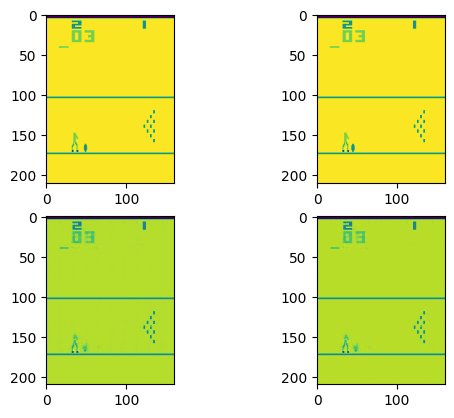

In [11]:
pretrained_filename = os.path.join(CHECKPOINT_PATH, "lightning_logs/version_1/checkpoints", "epoch=66-step=7035.ckpt")
if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
    model = Autoencoder.load_from_checkpoint(pretrained_filename)
original = test_set[300][0]
reconstructed = model(original)
reconstructed = reconstructed.squeeze(dim=0).detach()
print("Test Size:", test_set[1][0].size())

encoded_state = model.encoder(original)
print("Encoded State:", encoded_state.squeeze().size())

loss = model._get_reconstruction_loss(test_set[1])
print("Test Loss:", loss.item())

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(original[0,:,:].squeeze(dim=0))
axarr[0,1].imshow(original[1,:,:].squeeze(dim=0))
axarr[1,0].imshow(reconstructed[0,:,:].squeeze(dim=0))
axarr[1,1].imshow(reconstructed[1,:,:].squeeze(dim=0))
original[0,:,:].squeeze(dim=0).size()


In [5]:
%load_ext tensorboard
%tensorboard --logdir data/run_6/checkpoints/lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2976), started 1 day, 13:41:51 ago. (Use '!kill 2976' to kill it.)

In [5]:
data_dir = "data/run_"
i = 0
while os.path.exists(data_dir+str(i)):
    i += 1
run_dir = data_dir+str(i)
os.mkdir(run_dir)
os.mkdir(os.path.join(run_dir, 'train'))
os.mkdir(os.path.join(run_dir, 'test'))
os.mkdir(os.path.join(run_dir, 'checkpoints'))


EPISODES = 20
N = 10000
train_episodes = int(0.8*EPISODES)
path_train_df = pd.DataFrame(columns=['image path'])
path_validate_df = pd.DataFrame(columns=['image path'])
image_i = 0
for e in range(EPISODES):
    atari.env.reset()
    if e >= train_episodes:
        image_i = 0


    for i in range(N):
        # take a random action
        action = atari.env.action_space.sample()
        observation, reward, terminated, truncated, info = atari.env.step(action)

        image_name = game+'_'+str(image_i)+'.png'

        if e >= train_episodes:
            image_dir = os.path.join(run_dir, 'test', image_name)
            path_validate_df = pd.concat([path_validate_df, pd.Series({'image path': image_dir}).to_frame().T], ignore_index=True)
        else:
            image_dir = os.path.join(run_dir, 'train', image_name)
            path_train_df = pd.concat([path_train_df, pd.Series({'image path': image_dir}).to_frame().T], ignore_index=True)
        save_image(torch.Tensor(observation)/255, image_dir)

        image_i += 1
    
        
        # end game
        if terminated or truncated:
            break

path_train_df_dir = os.path.join(run_dir,'train','image_path.csv')
path_train_df.to_csv(path_train_df_dir)
path_validate_df_dir = os.path.join(run_dir,'test','image_path.csv')
path_validate_df.to_csv(path_validate_df_dir)